In [1]:
# Imports

from OverwatchProcessData import get_competitive_rank, get_vector_gamestats, general_stats
from OverwatchGatherData import Player, find_usernames

from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout

import matplotlib.pyplot as plt

import numpy as np
import os

np.random.seed(5)

Using TensorFlow backend.


In [2]:

better_general_stats = ["kpd"]

for stat in general_stats:
    
    if "avg" in stat:
        
        better_general_stats.append(stat)
                                   

better_general_stats

['kpd',
 'final_blows_avg_per_10_min',
 'solo_kills_avg_per_10_min',
 'eliminations_avg_per_10_min',
 'all_damage_done_avg_per_10_min',
 'melee_final_blows_avg_per_10_min',
 'barrier_damage_done_avg_per_10_min',
 'time_spent_on_fire_avg_per_10_min',
 'healing_done_avg_per_10_min',
 'objective_time_avg_per_10_min',
 'deaths_avg_per_10_min',
 'hero_damage_done_avg_per_10_min',
 'objective_kills_avg_per_10_min']

In [3]:
# Load Data

def load_data():

    unscaled_X, unscaled_y = [], []

    for filename in os.listdir('profiles'):

        player = Player.from_file(os.path.join('profiles', filename))

        rank = get_competitive_rank(player, 'us')

        if rank: # Only use data w/rank attached

            unscaled_X.append(get_vector_gamestats(player, 'us', 'competitive', stat_keys=better_general_stats))
            unscaled_y.append(rank)

    unscaled_X = np.array(unscaled_X, dtype=np.float64)
    unscaled_y = np.array(unscaled_y, dtype=np.float64)
    
    return unscaled_X, unscaled_y


In [4]:
# Standardize Data

def scale_data(unscaled_X, unscaled_y):
    
    scaler_X = StandardScaler()

    X = scaler_X.fit_transform(unscaled_X)
    y = unscaled_y
    
    return X, y, scaler_X


In [5]:
# Keras Model

def get_model():

    model = Sequential()
    model.add(Dense(12, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(20, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mean_squared_error', optimizer='adam') # MSE loss b/c regression
    
    return model


In [6]:
# Learning function

def fit_to_data(model, *args, **kwargs): # Wrapper for keras model.fit( ... )

    history = model.fit(*args, **kwargs, shuffle=True, verbose=0)
    
    return history


In [7]:
# Predict SR

def predict_sr(model, player):
    
    stats_vector = np.array([get_vector_gamestats(player, 'us', 'competitive', stat_keys=better_general_stats)])
    
    X = scaler_X.transform(stats_vector)

    y_matrix = model.predict(X)
    
    sr = np.squeeze(y_matrix)
    
    return int(sr)


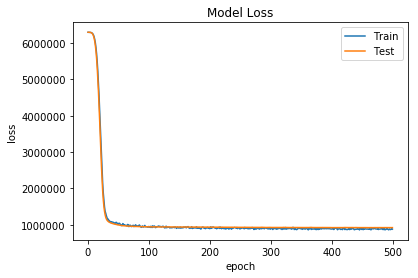

In [8]:
# Loads and trains model

X, y, scaler_X = scale_data(*load_data())

model = get_model()

history = fit_to_data(model, X, y, epochs=500, batch_size=128, validation_split=.10)

model.save('overwatch-sr-2.h5')

# Plot loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


In [ ]:

with open('test_names.txt', 'r') as test:

    for battletag in find_usernames(test.read()):
        
        player = Player.from_web_battletag(battletag)
        
        print("{} is {}, predicted {}".format(battletag, predict_sr(model, player), get_competitive_rank(player, 'us')))
